In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)  # show all columns
pd.set_option("display.width", None)     # don't wrap columns
pd.set_option("display.max_colwidth", None)  # don't truncate long text


# Importing CSV files

In [ ]:
import pandas as pd
import os

# Adjust these paths
input_folder = r'C:\# Online Courses\NYP\MLandOpsProj\c17'
output_file = 'combined_c17.csv'

# Remove existing output if you want a clean start
if os.path.exists(output_file):
    os.remove(output_file)

# Process all CSVs
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_folder, filename)

        # Get file prefix like 'c11'
        cohort = filename.split('.')[0]  # or use regex if format is inconsistent
        user_id = filename.split('.')[1].strip('p')
        combi_user_id = cohort.strip('c')+'0'+user_id

        print(f"Processing {filename}") # as {label}")

        # Read in chunks
        chunk_size = 100_000
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Keep only rows where 'activity_label' is not empty
            filtered_chunk = chunk[chunk['activity_label'].notna()].copy()
            # filtered_chunk['group_label'] = label
            filtered_chunk['user_id'] = combi_user_id

            # Append to output
            filtered_chunk.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)

    print("Saved to:", os.path.abspath(output_file))


Processing c17.p001.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p002.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p003.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p004.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p005.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p006.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p007.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p008.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p009.csv
Saved to: c:\# Online Courses\NYP\MLandOpsProj\working\iti113_adls\combined_c17.csv
Processing c17.p010.csv
Save

## Dryad (ArWISE) dataset
https://datadryad.org/landing/show?id=doi%3A10.5061%2Fdryad.jdfn2z3nm#readme

In [ ]:
# Load the combined dataset
df = pd.read_csv("./combined_c17.csv")

### Brief overview of combined dataset

In [20]:
# First few rows
print (df.head(), '\n\n')

      timestamp         x         y         z sensor_type  activity_label  \
0  1.820000e+11  0.126893 -0.033519  0.067038         acc  Walking slowly   
1  1.820000e+11 -0.268151 -0.167594  0.122104         acc  Walking slowly   
2  1.830000e+11 -0.883460 -0.119710 -0.392649         acc  Walking slowly   
3  1.830000e+11 -0.253785  0.605733 -0.526724         acc  Walking slowly   
4  1.830000e+11 -0.189142  0.136469  0.165200         acc  Walking slowly   

   user_id  
0        1  
1        1  
2        1  
3        1  
4        1   




In [21]:
# Summarising structure
print(df.info(), '\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568079 entries, 0 to 2568078
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       float64
 1   x               float64
 2   y               float64
 3   z               float64
 4   sensor_type     object 
 5   activity_label  object 
 6   user_id         int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 137.2+ MB
None 




In [22]:
print(df.head())

      timestamp         x         y         z sensor_type  activity_label  \
0  1.820000e+11  0.126893 -0.033519  0.067038         acc  Walking slowly   
1  1.820000e+11 -0.268151 -0.167594  0.122104         acc  Walking slowly   
2  1.830000e+11 -0.883460 -0.119710 -0.392649         acc  Walking slowly   
3  1.830000e+11 -0.253785  0.605733 -0.526724         acc  Walking slowly   
4  1.830000e+11 -0.189142  0.136469  0.165200         acc  Walking slowly   

   user_id  
0        1  
1        1  
2        1  
3        1  
4        1  


Timestamp values are not always changing, and not used in our analysis

In [23]:
# Drop timestamp values
df = df.drop(columns='timestamp')

## Feature engineering

### Form discrete difference features from time-based data

In [26]:
# Calculate diff
df[["diff_x", "diff_y", "diff_z"]] = (
    df.groupby(["user_id", "activity_label", "sensor_type"])[["x", "y", "z"]]
       .diff()
)

# Drop the first row of each group (where diffs are NaN)
df = df[df.groupby(["user_id", "activity_label", "sensor_type"]).cumcount() != 0].reset_index(drop=True)


In [27]:
print(df['diff_x'].head())

0   -0.615310
1    0.629675
2    0.064643
3   -1.158794
4    1.414973
Name: diff_x, dtype: float64


In [28]:
df['diff_x'].isnull().sum()

np.int64(22)

### Form vector sum features from 3-axis time-based data

In [29]:
# Create a new column "vec_sum", initialize with NaN
df["vec_sum"] = np.nan  

# Compute only for sensor types not equal to 'hrt'
mask = df["sensor_type"] != "hrt"
df.loc[mask, "vec_sum"] = np.sqrt(
    df.loc[mask, "x"]**2 +
    df.loc[mask, "y"]**2 +
    df.loc[mask, "z"]**2
)

In [30]:
print(df.head())

          x         y         z sensor_type  activity_label  user_id  \
0 -0.883460 -0.119710 -0.392649         acc  Walking slowly        1   
1 -0.253785  0.605733 -0.526724         acc  Walking slowly        1   
2 -0.189142  0.136469  0.165200         acc  Walking slowly        1   
3 -1.347936  0.086191  0.136469         acc  Walking slowly        1   
4  0.067038 -0.191536 -0.189142         acc  Walking slowly        1   

     diff_x    diff_y    diff_z   vec_sum  
0 -0.615310  0.047884 -0.514753  0.974169  
1  0.629675  0.725443 -0.134075  0.841878  
2  0.064643 -0.469264  0.691924  0.285814  
3 -1.158794 -0.050278 -0.028730  1.357565  
4  1.414973 -0.277727 -0.325611  0.277407  


### Form mean, std of time-based data

In [31]:
# Filter rows with expected sensor types only (optional for safety)
valid_sensors = ['gyro', 'acc', 'acg', 'mgm', 'hrt']
df = df[df['sensor_type'].isin(valid_sensors)]


In [32]:
import pandas as pd

# Mapping sensor types to your naming style
sensor_name_map = {
    'gyro': 'rotation_rate',
    'acg': 'user_acceleration',
    'acc': 'acceleration',
    'mgm': 'magnetometer',
    'hrt': 'heart_rate'
}

rows = []

# Group by user, activity, sensor
for (user_id, activity_label, sensor_type), group in df.groupby(['user_id', 'activity_label', 'sensor_type']):
    sensor = sensor_name_map.get(sensor_type, sensor_type)

    row = {
        'user_id': user_id,
        'activity_label': activity_label
    }

    # Mean and std of x,y,z,diff_x,diff_y,diff_z,vec_sum
    for axis in ['x', 'y', 'z', 'diff_x', 'diff_y', 'diff_z', 'vec_sum']:
        row[f'{sensor}_{axis}_mean'] = group[axis].astype(float).mean()
        row[f'{sensor}_{axis}_std'] = group[axis].astype(float).std()
        # row[f'{sensor}_{axis}'] = group[axis].astype(float).iloc[-1]  # last value # not keeping the original time-series data

    rows.append(row)

# Convert to flat dataframe
df2 = pd.DataFrame(rows)

# Merge all sensors for same user_id/activity_label
df2 = (
    df2
    .groupby(['user_id', 'activity_label'], as_index=False)
    .first()
)


In [33]:
# Drop heart rate y and z since these are empty

drop_cols = ['heart_rate_y','heart_rate_z','heart_rate_diff_y','heart_rate_diff_z','heart_rate_vec_sum']
columns_to_drop = [col for col in df2.columns if any(k in col.lower() for k in drop_cols)]

df2 = df2.drop(columns=columns_to_drop)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 62 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         980 non-null    int64  
 1   activity_label                  980 non-null    object 
 2   acceleration_x_mean             980 non-null    float64
 3   acceleration_x_std              980 non-null    float64
 4   acceleration_y_mean             980 non-null    float64
 5   acceleration_y_std              980 non-null    float64
 6   acceleration_z_mean             980 non-null    float64
 7   acceleration_z_std              980 non-null    float64
 8   acceleration_diff_x_mean        980 non-null    float64
 9   acceleration_diff_x_std         980 non-null    float64
 10  acceleration_diff_y_mean        980 non-null    float64
 11  acceleration_diff_y_std         980 non-null    float64
 12  acceleration_diff_z_mean        980 

### Add volunteer details to dataset

In [34]:
details = pd.read_csv("./volunteer_details.csv")
print(details.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Subject Id         41 non-null     int64  
 1   Gender             41 non-null     object 
 2   Height (cm)        41 non-null     float64
 3   Weight (KG)        41 non-null     float64
 4   Age                41 non-null     int64  
 5   Heart Rate (base)  41 non-null     int64  
 6   Health condition   41 non-null     object 
dtypes: float64(2), int64(3), object(2)
memory usage: 2.4+ KB
None


In [35]:
# Convert both ID columns to int type before merging
df2['user_id'] = df2['user_id'].astype(int)


# Map Health condition to health_status
details['health_status'] = details['Health condition'].apply(
    lambda x: 'Unhealthy' if any(cond in str(x).lower() for cond in ['obese', 'overweight', 'arthritis']) else 'Healthy'
)

# Create age_group based on threshold
details['age_group'] = np.where(details['Age'] <= 35, 'young', 'older')


# Merge the group_label into df based on user_id
df2 = df2.merge(details[['Subject Id', 'health_status', 'age_group']],
              left_on='user_id', right_on='Subject Id', how='left')

# Drop the temporary column
df2 = df2.drop(columns=['Subject Id'])  # Drop Subject Id after merge

In [36]:
print(df2['health_status'].unique())
print(df2['age_group'].unique())

['Healthy' 'Unhealthy']
['young' 'older']


### Overview after feature engineering

In [37]:
print(df2.head())

   user_id                      activity_label  acceleration_x_mean  \
0        1  Backward fall from seated position            -0.111528   
1        1              Climbing down normally            -3.507931   
2        1                Climbing down slowly            -0.312407   
3        1                Climbing up normally            -0.717512   
4        1                  Climbing up slowly            -0.263494   

   acceleration_x_std  acceleration_y_mean  acceleration_y_std  \
0            1.608537             0.201592            1.240818   
1            5.796653            -0.657395            4.961398   
2            1.407604            -0.159251            1.608353   
3            3.649225            -0.115071            3.080969   
4            1.578956            -0.096732            1.995569   

   acceleration_z_mean  acceleration_z_std  acceleration_diff_x_mean  \
0            -0.207733            1.094748                 -0.000125   
1            -2.213679          

In [38]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         980 non-null    int64  
 1   activity_label                  980 non-null    object 
 2   acceleration_x_mean             980 non-null    float64
 3   acceleration_x_std              980 non-null    float64
 4   acceleration_y_mean             980 non-null    float64
 5   acceleration_y_std              980 non-null    float64
 6   acceleration_z_mean             980 non-null    float64
 7   acceleration_z_std              980 non-null    float64
 8   acceleration_diff_x_mean        980 non-null    float64
 9   acceleration_diff_x_std         980 non-null    float64
 10  acceleration_diff_y_mean        980 non-null    float64
 11  acceleration_diff_y_std         980 non-null    float64
 12  acceleration_diff_z_mean        980 

## Data cleaning

In [39]:
for column in df2.columns:
    print(df2[column].value_counts(),'\n')

user_id
1     24
2     24
3     24
4     24
5     24
6     24
7     24
8     24
9     24
10    24
11    24
12    24
13    24
14    24
15    24
16    24
17    24
18    24
19    24
20    24
21    24
22    24
23    24
24    24
25    24
26    24
27    24
28    24
29    24
30    24
32    24
33    24
34    24
38    24
35    24
36    24
37    24
40    24
39    24
41    24
31    20
Name: count, dtype: int64 

activity_label
Backward fall from seated position                   41
Climbing down normally                               41
Climbing down slowly                                 41
Climbing up normally                                 41
Climbing up slowly                                   41
Jumping                                              41
Jogging                                              41
Grabbing while falling                               41
Swinging hands                                       41
Right fall                                           41
Seated on bed and fa

### Duplicates handling

In [40]:
# Check for duplicated rows
print('Duplicated rows: ')
print(df2.duplicated().sum())
duplicates = df2[df2.duplicated(keep=False)]
print(duplicates)

# Check for duplicated columns
print('Duplicated cols: ')
print(df2.columns[df2.columns.duplicated()].tolist())


# Check for duplicate rows excluding 'user_id'
duplicates_except_id = df2[df2.drop(columns='user_id').duplicated(keep=False)]
# Sort to view nicely
duplicates_except_id = duplicates_except_id.sort_values(by=list(df2.columns.difference(['user_id'])))
print('Duplicate rows (except user_id):')
print(duplicates_except_id)


Duplicated rows: 
0
Empty DataFrame
Columns: [user_id, activity_label, acceleration_x_mean, acceleration_x_std, acceleration_y_mean, acceleration_y_std, acceleration_z_mean, acceleration_z_std, acceleration_diff_x_mean, acceleration_diff_x_std, acceleration_diff_y_mean, acceleration_diff_y_std, acceleration_diff_z_mean, acceleration_diff_z_std, acceleration_vec_sum_mean, acceleration_vec_sum_std, user_acceleration_x_mean, user_acceleration_x_std, user_acceleration_y_mean, user_acceleration_y_std, user_acceleration_z_mean, user_acceleration_z_std, user_acceleration_diff_x_mean, user_acceleration_diff_x_std, user_acceleration_diff_y_mean, user_acceleration_diff_y_std, user_acceleration_diff_z_mean, user_acceleration_diff_z_std, user_acceleration_vec_sum_mean, user_acceleration_vec_sum_std, rotation_rate_x_mean, rotation_rate_x_std, rotation_rate_y_mean, rotation_rate_y_std, rotation_rate_z_mean, rotation_rate_z_std, rotation_rate_diff_x_mean, rotation_rate_diff_x_std, rotation_rate_diff_

Conclusion: no duplicates

In [41]:
# Drop duplicate rows (keeping first of each)
df2 = df2.drop_duplicates(keep="first")


### Standardize activities

In [42]:
# Convert to lowercase for easier matching
df2['activity_label'] = df2['activity_label'].astype(str).str.lower()

# Define mapping function
def categorize_activity(label):
    if 'eat' in label or 'meal' in label or 'drink' in label:
        return 'Eat'
    elif 'errand' in label or 'shop' in label or 'store' in label or 'grocer' in label:
        return 'Errands'
    elif 'run' in label or 'jog' in label or 'walk' in label or 'climb' in label or 'exercise' in label or  'workout' in label or 'cycle' in label or  'jump' in label:
        return 'Exercise'
    elif 'brush' in label or 'toilet' in label or 'shower' in label or 'hygiene' in label or 'groom' in label or 'bath' in label:
        return 'Hygiene'
    # elif 'run' in label or 'jog' in label:
    #     return 'Run'
    # elif 'walk' in label:
    #     return 'Walk'
    # elif 'climb' in label:
    #     return 'Climbing stairs'
    # elif 'sit' in label:
    #     return 'Sitting down'
    # elif 'exercise' in label or  'workout' in label or 'cycle' in label or  'jump' in label:
    #     return 'Other exercise'
    elif 'game' in label or 'gaming' in label or 'play' in label or 'art' in label or 'tv' in label or 'read' in label or 'video' in label:
        return 'Hobby'
    elif 'clean' in label or 'chores' in label or 'housework' in label or 'dishes' in label or 'cook' in label:
        return 'Chores'
    elif 'relax' in label or 'chill' in label or 'rest' in label:
        return 'Relax'
    elif 'sleep' in label or 'lying' in label or 'lie' in label:
        return 'Sleep'
    elif 'social' in label or 'talk' in label or 'phone' in label or 'message' in label or 'text' in label:
        return 'Socialize'
    elif 'travel' in label or 'bus' in label or 'drive' in label or 'commute' in label: # or 'fly' in label
        return 'Travel'
    elif 'work' in label or 'school' in label or 'lab' in label or 'homework' in label or 'report' in label or 'meeting' in label or 'class' in label or 'research' in label or 'study' in label:
        return 'Work'
    elif 'fall' in label:
        return 'Fall'
    else:
        return None # rows not in the above categories will be dropped


# Apply the categorization
df2['activity_label'] = df2['activity_label'].apply(categorize_activity)

# Drop rows where category is None (would have been 'Other')
df2 = df2[df2['activity_label'].notna()]

In [43]:
print(df2['activity_label'].unique())

['Eat' 'Exercise' 'Fall' 'Sleep']


## Data Analysis

### Review dataset after cleaning

In [168]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, 0 to 979
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         816 non-null    int64  
 1   activity_label                  816 non-null    object 
 2   acceleration_x_mean             816 non-null    float64
 3   acceleration_x_std              816 non-null    float64
 4   acceleration_y_mean             816 non-null    float64
 5   acceleration_y_std              816 non-null    float64
 6   acceleration_z_mean             816 non-null    float64
 7   acceleration_z_std              816 non-null    float64
 8   acceleration_diff_x_mean        816 non-null    float64
 9   acceleration_diff_x_std         816 non-null    float64
 10  acceleration_diff_y_mean        816 non-null    float64
 11  acceleration_diff_y_std         816 non-null    float64
 12  acceleration_diff_z_mean        816 non-n

### Descriptive statistics for each activity

In [170]:
# Distribution of each numeric feature by activity_label 

for label, group in df2.groupby("activity_label"):
    print(f"\n=== Stats for activity: {label} ===")
    print(group.describe(include='number').T)


=== Stats for activity: Eat ===
                                count       mean        std         min  \
user_id                          82.0  21.000000  11.904974    1.000000   
acceleration_x_mean              82.0  -0.003839   0.252626   -0.936248   
acceleration_x_std               82.0   1.474390   0.809751    0.072103   
acceleration_y_mean              82.0   0.142167   0.292396   -1.462558   
acceleration_y_std               82.0   1.643598   0.905554    0.187322   
acceleration_z_mean              82.0  -0.192961   0.195045   -0.743579   
acceleration_z_std               82.0   1.503872   0.793649    0.191881   
acceleration_diff_x_mean         82.0   0.002251   0.010907   -0.026220   
acceleration_diff_x_std          82.0   1.093485   0.715559    0.086446   
acceleration_diff_y_mean         82.0   0.001282   0.013352   -0.043689   
acceleration_diff_y_std          82.0   1.151836   0.894230    0.193868   
acceleration_diff_z_mean         82.0  -0.003217   0.013766   -0.06

### Data Visualization

#### Categorical data visualization
For this dataset, these categorical features do not affect each other as each participant did all the activities for this dataset.
* The other categorical features are independent of activity_label. i.e. health_status and age_group counts would be same across all activities.
* The same proportion of activities are done by each person.
* Any of these categories can be used as the prediction label, with the other 2 categorical features dropped.

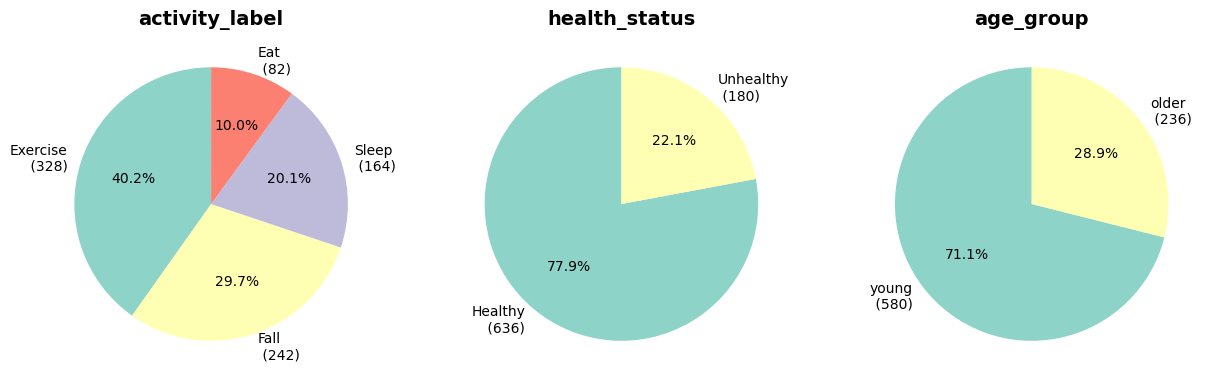

In [184]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i,col in enumerate(['activity_label', 'health_status', 'age_group']):
    # Calculate health_status distribution
    counts = df2[col].value_counts()
    percentages = df2[col].value_counts(normalize=True) * 100
    # Create labels with counts
    labels_with_counts = [f"{label}\n ({count})" for label, count in zip(counts.index, counts.values)]

    # Pie chart
    colors = plt.cm.Set3(range(len(counts)))
    wedges, texts, autotexts = axes[i].pie(
        counts.values, 
        labels=labels_with_counts, 
        autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].set_title(col, fontsize=14, fontweight='bold')

plt.show()

#### Numeric data visualization by activity

['acceleration_x_mean', 'acceleration_y_mean', 'acceleration_z_mean', 'acceleration_diff_x_mean', 'acceleration_diff_y_mean', 'acceleration_diff_z_mean', 'acceleration_vec_sum_mean', 'user_acceleration_x_mean', 'user_acceleration_y_mean', 'user_acceleration_z_mean', 'user_acceleration_diff_x_mean', 'user_acceleration_diff_y_mean', 'user_acceleration_diff_z_mean', 'user_acceleration_vec_sum_mean', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'rotation_rate_diff_x_mean', 'rotation_rate_diff_y_mean', 'rotation_rate_diff_z_mean', 'rotation_rate_vec_sum_mean', 'heart_rate_x_mean', 'heart_rate_diff_x_mean', 'magnetometer_x_mean', 'magnetometer_y_mean', 'magnetometer_z_mean', 'magnetometer_diff_x_mean', 'magnetometer_diff_y_mean', 'magnetometer_diff_z_mean', 'magnetometer_vec_sum_mean']


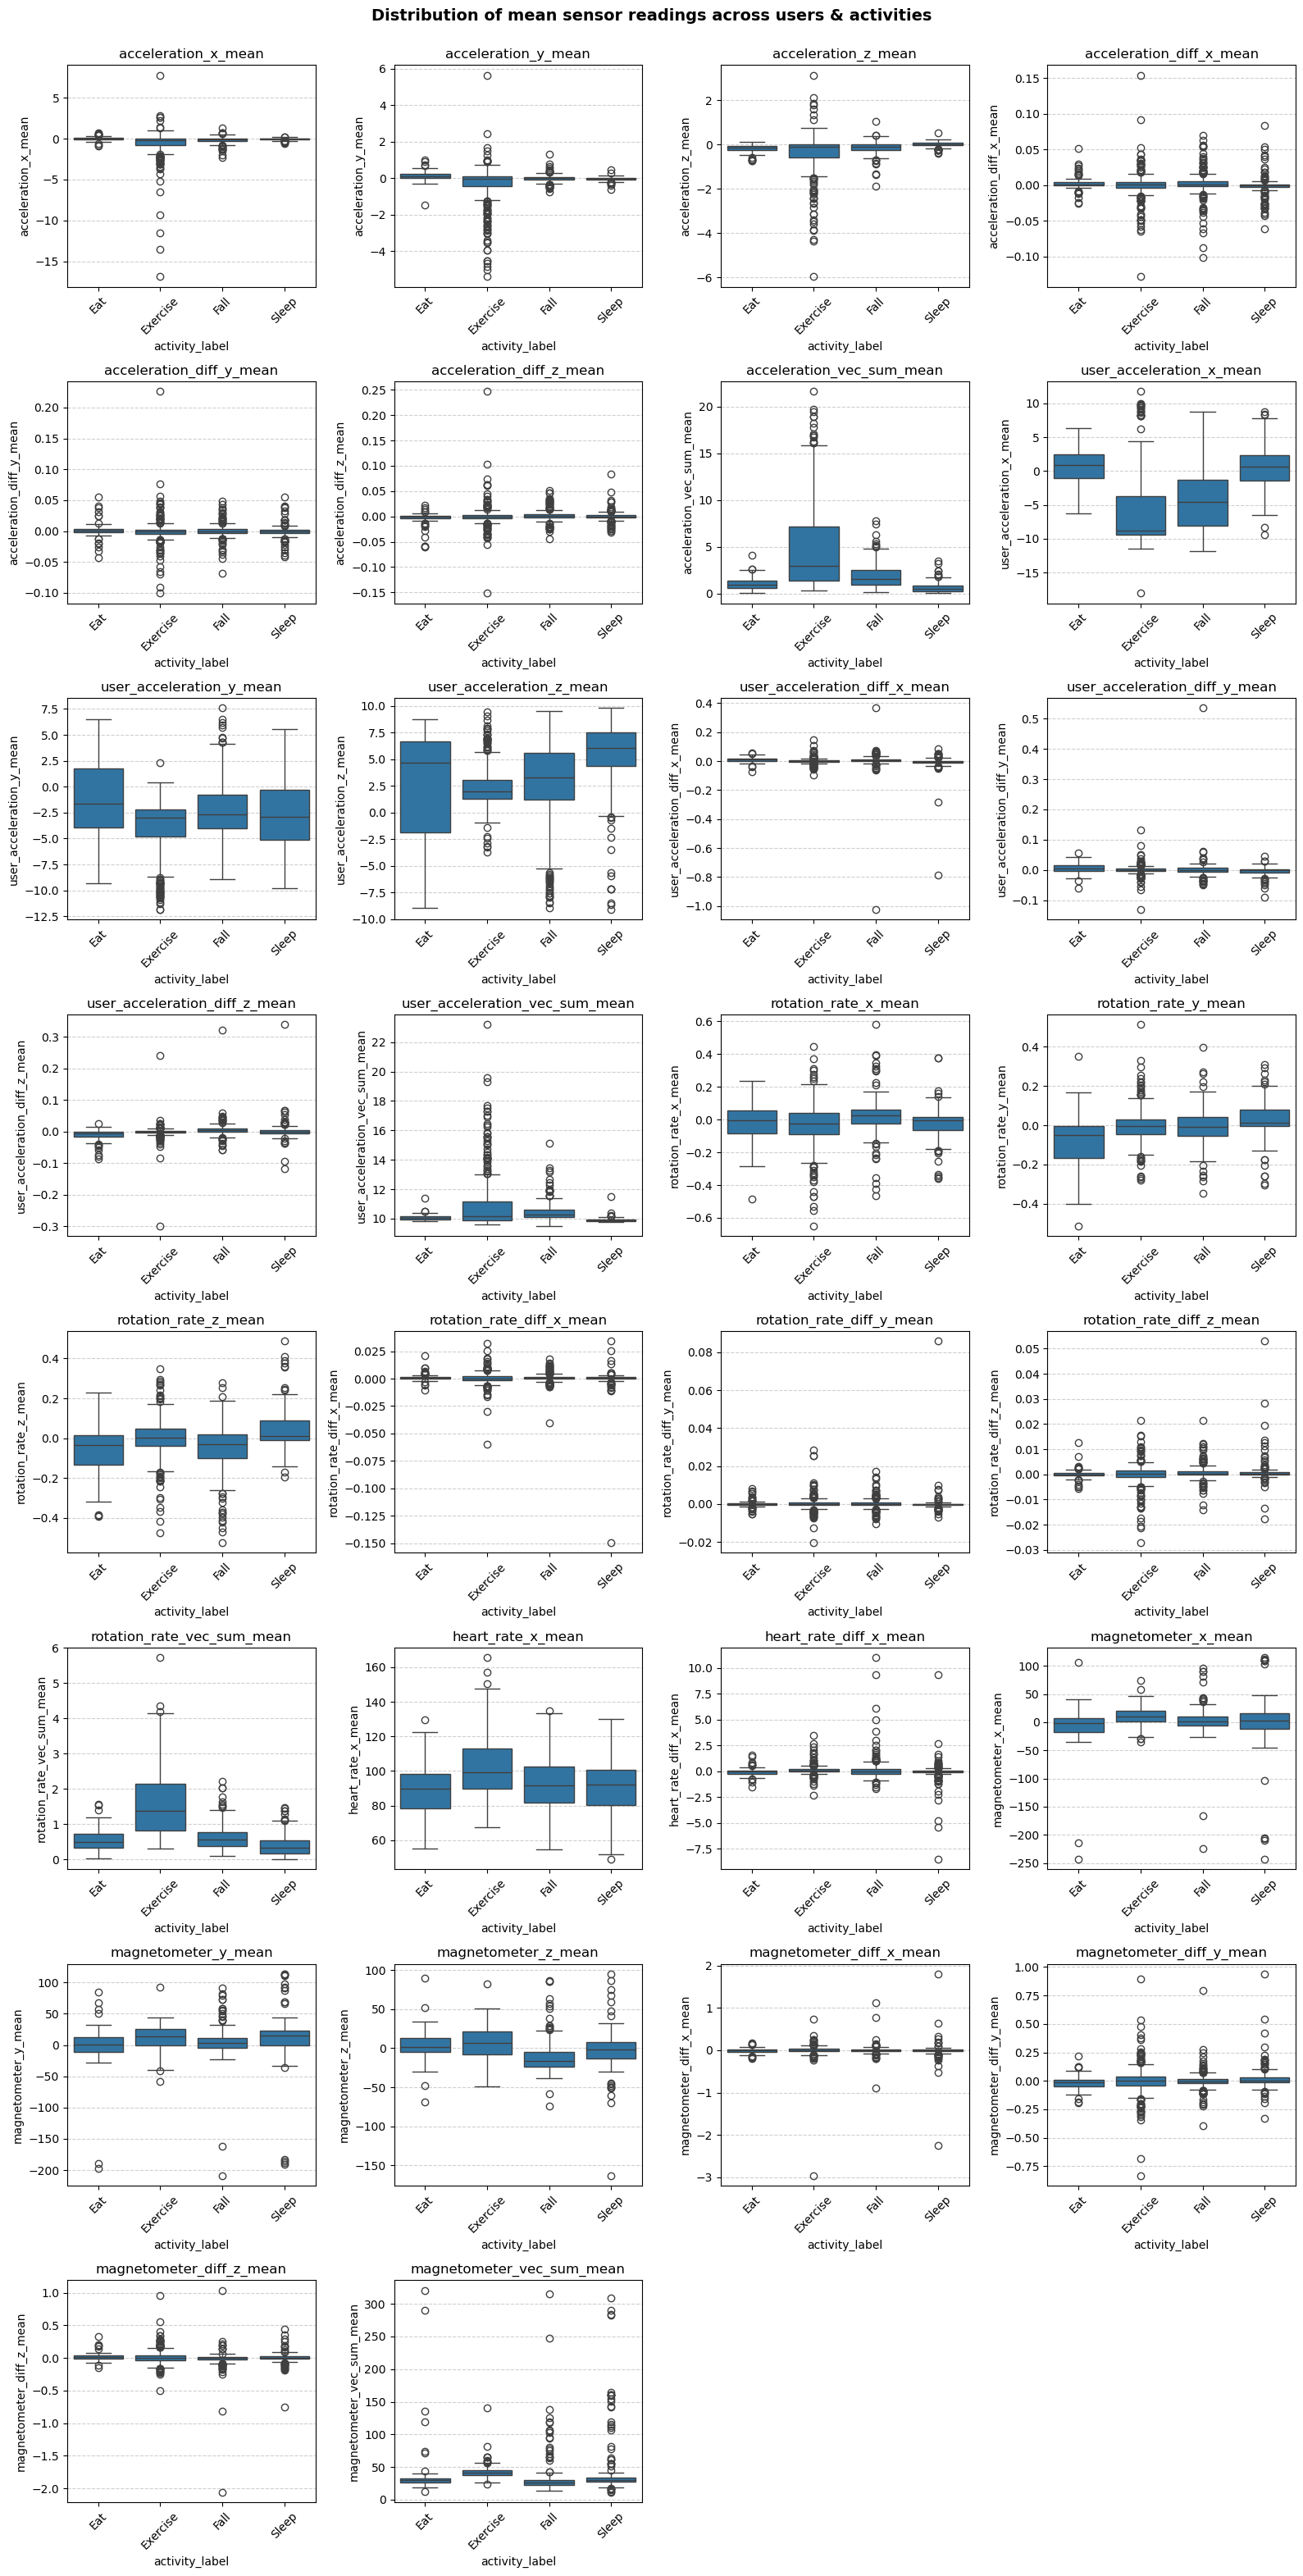

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Take only mean features for visualization
sensor_features = [col for col in df2.columns if 'mean' in col]
print(sensor_features)

n_features = len(sensor_features)
n_cols = 4 # number of columns 
n_rows = math.ceil(n_features / n_cols)  # compute required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten in case of multiple rows for easy indexing

for i, feature in enumerate(sensor_features):
    sns.boxplot(x='activity_label', y=feature, data=df2, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].tick_params(axis='x', rotation=45)

# Turn off any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.suptitle('Distribution of mean sensor readings across users & activities', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave space for suptitle
plt.show()



**Interpreting mean:**

Mean of sensor readings is the average of all the time-based sensor readings for each user and each activity,
so these box plots are intended to show the possible spread/distribution of average sensor readings across users.

Distribution across users:
* Higher median across users, in mean sensor reading - users have higher average sensor readings
* Greater spread across users, in mean sensor reading - users differ in their average sensor readings

**Interpreting mean of diff:**

Mean of the discrete difference of sensor readings show the average step-to-step change in the sensor data over time
* 0 mean difference - on average, readings don't drift over time
* Positive mean difference - on average, readings increase over time

Distribution across users:
* Higher median across users, in mean of diff of sensor reading - most users show a stronger upward trend in their sensor readings for that activity
* Greater spread across users, in mean of diff of sensor reading - users differ in their overall trend of sensor readings for that activity

**Observations on median/spread of mean sensor readings, across users and activities:**

Main observations:
* acceleration x,y,z,vector_sum: 
    * obvious larger variation across users during exercise, shown by greater spread (longer whiskers) and outliers in the box plot.
* rotation rate vector_sum mean: 
    * higher mean & greater spread of for exercise, compared to other activities
* heart rate mean:
    * higher mean heart rate values for exercise, shown by higher range of mean values
* diff-related data show small variation across users:
    * This makes sense because we don't expect diff in sensor readings to be high (since the sensor used is the same), hence the mean diff should be close to 0 across all sensors and activities.
    * probably low feature importance

Others:
* magnetometer mean: 
    * all median of magnetometer mean values are close to 0
    * for magnetometer z mean values, the median is lower for during falls
* user acceleration (linear acceleration) x,y,z,vector_sum mean: 
    * lower median value for x and z mean user acceleration during exercise
    * no outliers during eating (shown by circles)
* rotation rate x,y,z mean: 
    * all activities have the median of the mean sensor values close to 0

['acceleration_x_std', 'acceleration_y_std', 'acceleration_z_std', 'acceleration_diff_x_std', 'acceleration_diff_y_std', 'acceleration_diff_z_std', 'acceleration_vec_sum_std', 'user_acceleration_x_std', 'user_acceleration_y_std', 'user_acceleration_z_std', 'user_acceleration_diff_x_std', 'user_acceleration_diff_y_std', 'user_acceleration_diff_z_std', 'user_acceleration_vec_sum_std', 'rotation_rate_x_std', 'rotation_rate_y_std', 'rotation_rate_z_std', 'rotation_rate_diff_x_std', 'rotation_rate_diff_y_std', 'rotation_rate_diff_z_std', 'rotation_rate_vec_sum_std', 'heart_rate_x_std', 'heart_rate_diff_x_std', 'magnetometer_x_std', 'magnetometer_y_std', 'magnetometer_z_std', 'magnetometer_diff_x_std', 'magnetometer_diff_y_std', 'magnetometer_diff_z_std', 'magnetometer_vec_sum_std']


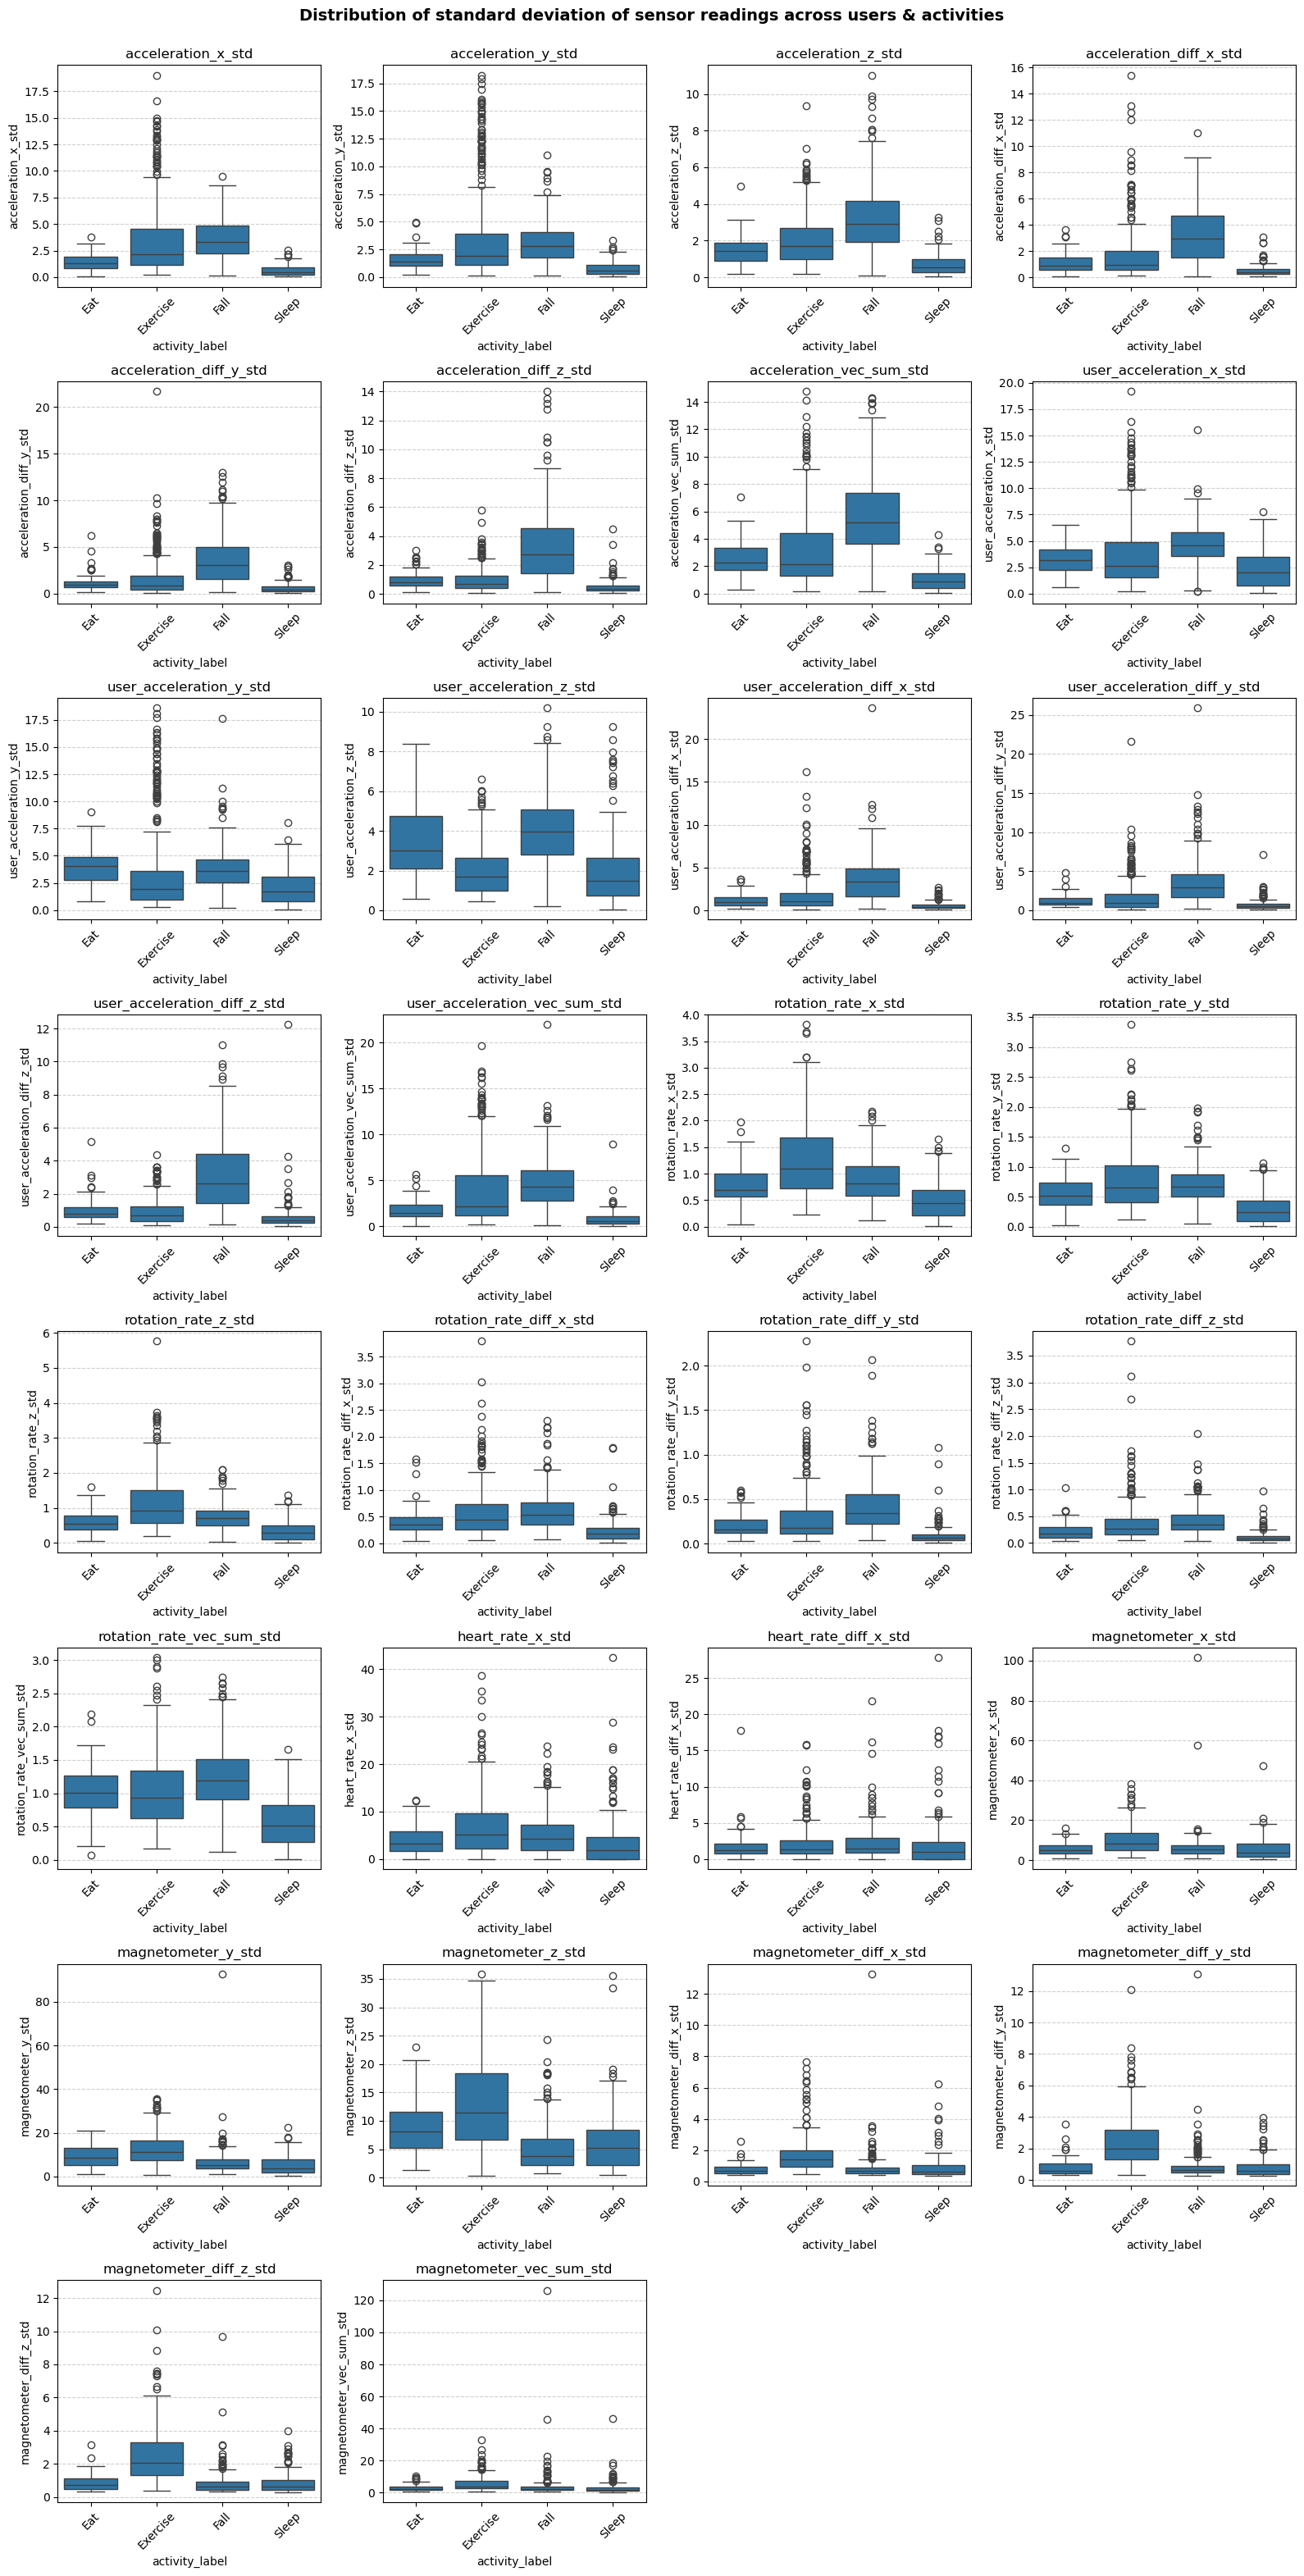

In [174]:
# Take only std features for visualization
sensor_features = [col for col in df2.columns if 'std' in col]
print(sensor_features)

n_features = len(sensor_features)
n_cols = 4 # number of columns 
n_rows = math.ceil(n_features / n_cols)  # compute required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten in case of multiple rows for easy indexing

for i, feature in enumerate(sensor_features):
    sns.boxplot(x='activity_label', y=feature, data=df2, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].tick_params(axis='x', rotation=45)

# Turn off any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.suptitle('Distribution of standard deviation of sensor readings across users & activities', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave space for suptitle
plt.show()

**Interpreting standard deviation:**
Standard deviation of sensor readings is a measure of the variability of the time-based sensor readings,
so these box plots are intended to show the possible spread/distribution of standard deviation in sensor readings across users.

Distribution across users:
* Higher median in standard deviation - across users, higher typical variability
* Greater spread in standard deviation - some users have more variable sensor readings than others
* Outliers - exceptionally unstable or stable sensor readings

**Interpreting standard deviation of diff:**
Standard deviation of the discrete difference of sensor readings show the variation in the magnitude of change of the sensor readings.
* Higher standard deviation of diff - more variation in the magnitude of change of the sensor readings in time

Distribution across users
* Higher median in standard deviation of diff - across users, more variation in the magnitude of change of the sensor readings in time
* Greater spread in standard deviation of diff - less consistency across users, some users have slower changes in sensor readings.

**Observations on median/spread of standard deviation of sensor readings, across users and activities:**
Main observations:
* acceleration x,y: greatest spread & outliers during exercise
* acceleration z, discrete difference of x,y,z, vector sum: greatest spread & highest median std during falls
    * highest median: typical user's acceleration signals change most erratically during falls
    * greatest spread: users differ in how their acceleration change during falls. some falls are more violent.
* user acceleration (linear acceleration) diff x,y,z: highest median & greatest spread during falls
    * highest median: typical user's linear acceleration signals change most erratically during falls
    * greatest spread: users differ in how their linear acceleration change during falls. some falls are more violent.

Others:
* rotation rate x,y,z: 
    * similar median std across activities
    * greater spread in std during exercise
* rotation rate diff x,y,z:
    * similar median std across activities
* rotation rate vector sum:
    * lower median std during sleep - lower variation in rotation rate across users
* heart rate std:
    * higher median heart rate standard deviation across users during exercise - higher variation in heart rate across users
* magnetometer z std:
    * greater spread during exercise - more variation in magnetometer reading variability across users
* magnetometer diff x,y,z:
    * greater spread during exercise - less consistency across users, some users have slower changes in sensor readings. possibly due to different types of exercise.
    

#### Numeric data visualization by health status

['acceleration_x_mean', 'acceleration_y_mean', 'acceleration_z_mean', 'acceleration_diff_x_mean', 'acceleration_diff_y_mean', 'acceleration_diff_z_mean', 'acceleration_vec_sum_mean', 'user_acceleration_x_mean', 'user_acceleration_y_mean', 'user_acceleration_z_mean', 'user_acceleration_diff_x_mean', 'user_acceleration_diff_y_mean', 'user_acceleration_diff_z_mean', 'user_acceleration_vec_sum_mean', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'rotation_rate_diff_x_mean', 'rotation_rate_diff_y_mean', 'rotation_rate_diff_z_mean', 'rotation_rate_vec_sum_mean', 'heart_rate_x_mean', 'heart_rate_diff_x_mean', 'magnetometer_x_mean', 'magnetometer_y_mean', 'magnetometer_z_mean', 'magnetometer_diff_x_mean', 'magnetometer_diff_y_mean', 'magnetometer_diff_z_mean', 'magnetometer_vec_sum_mean']


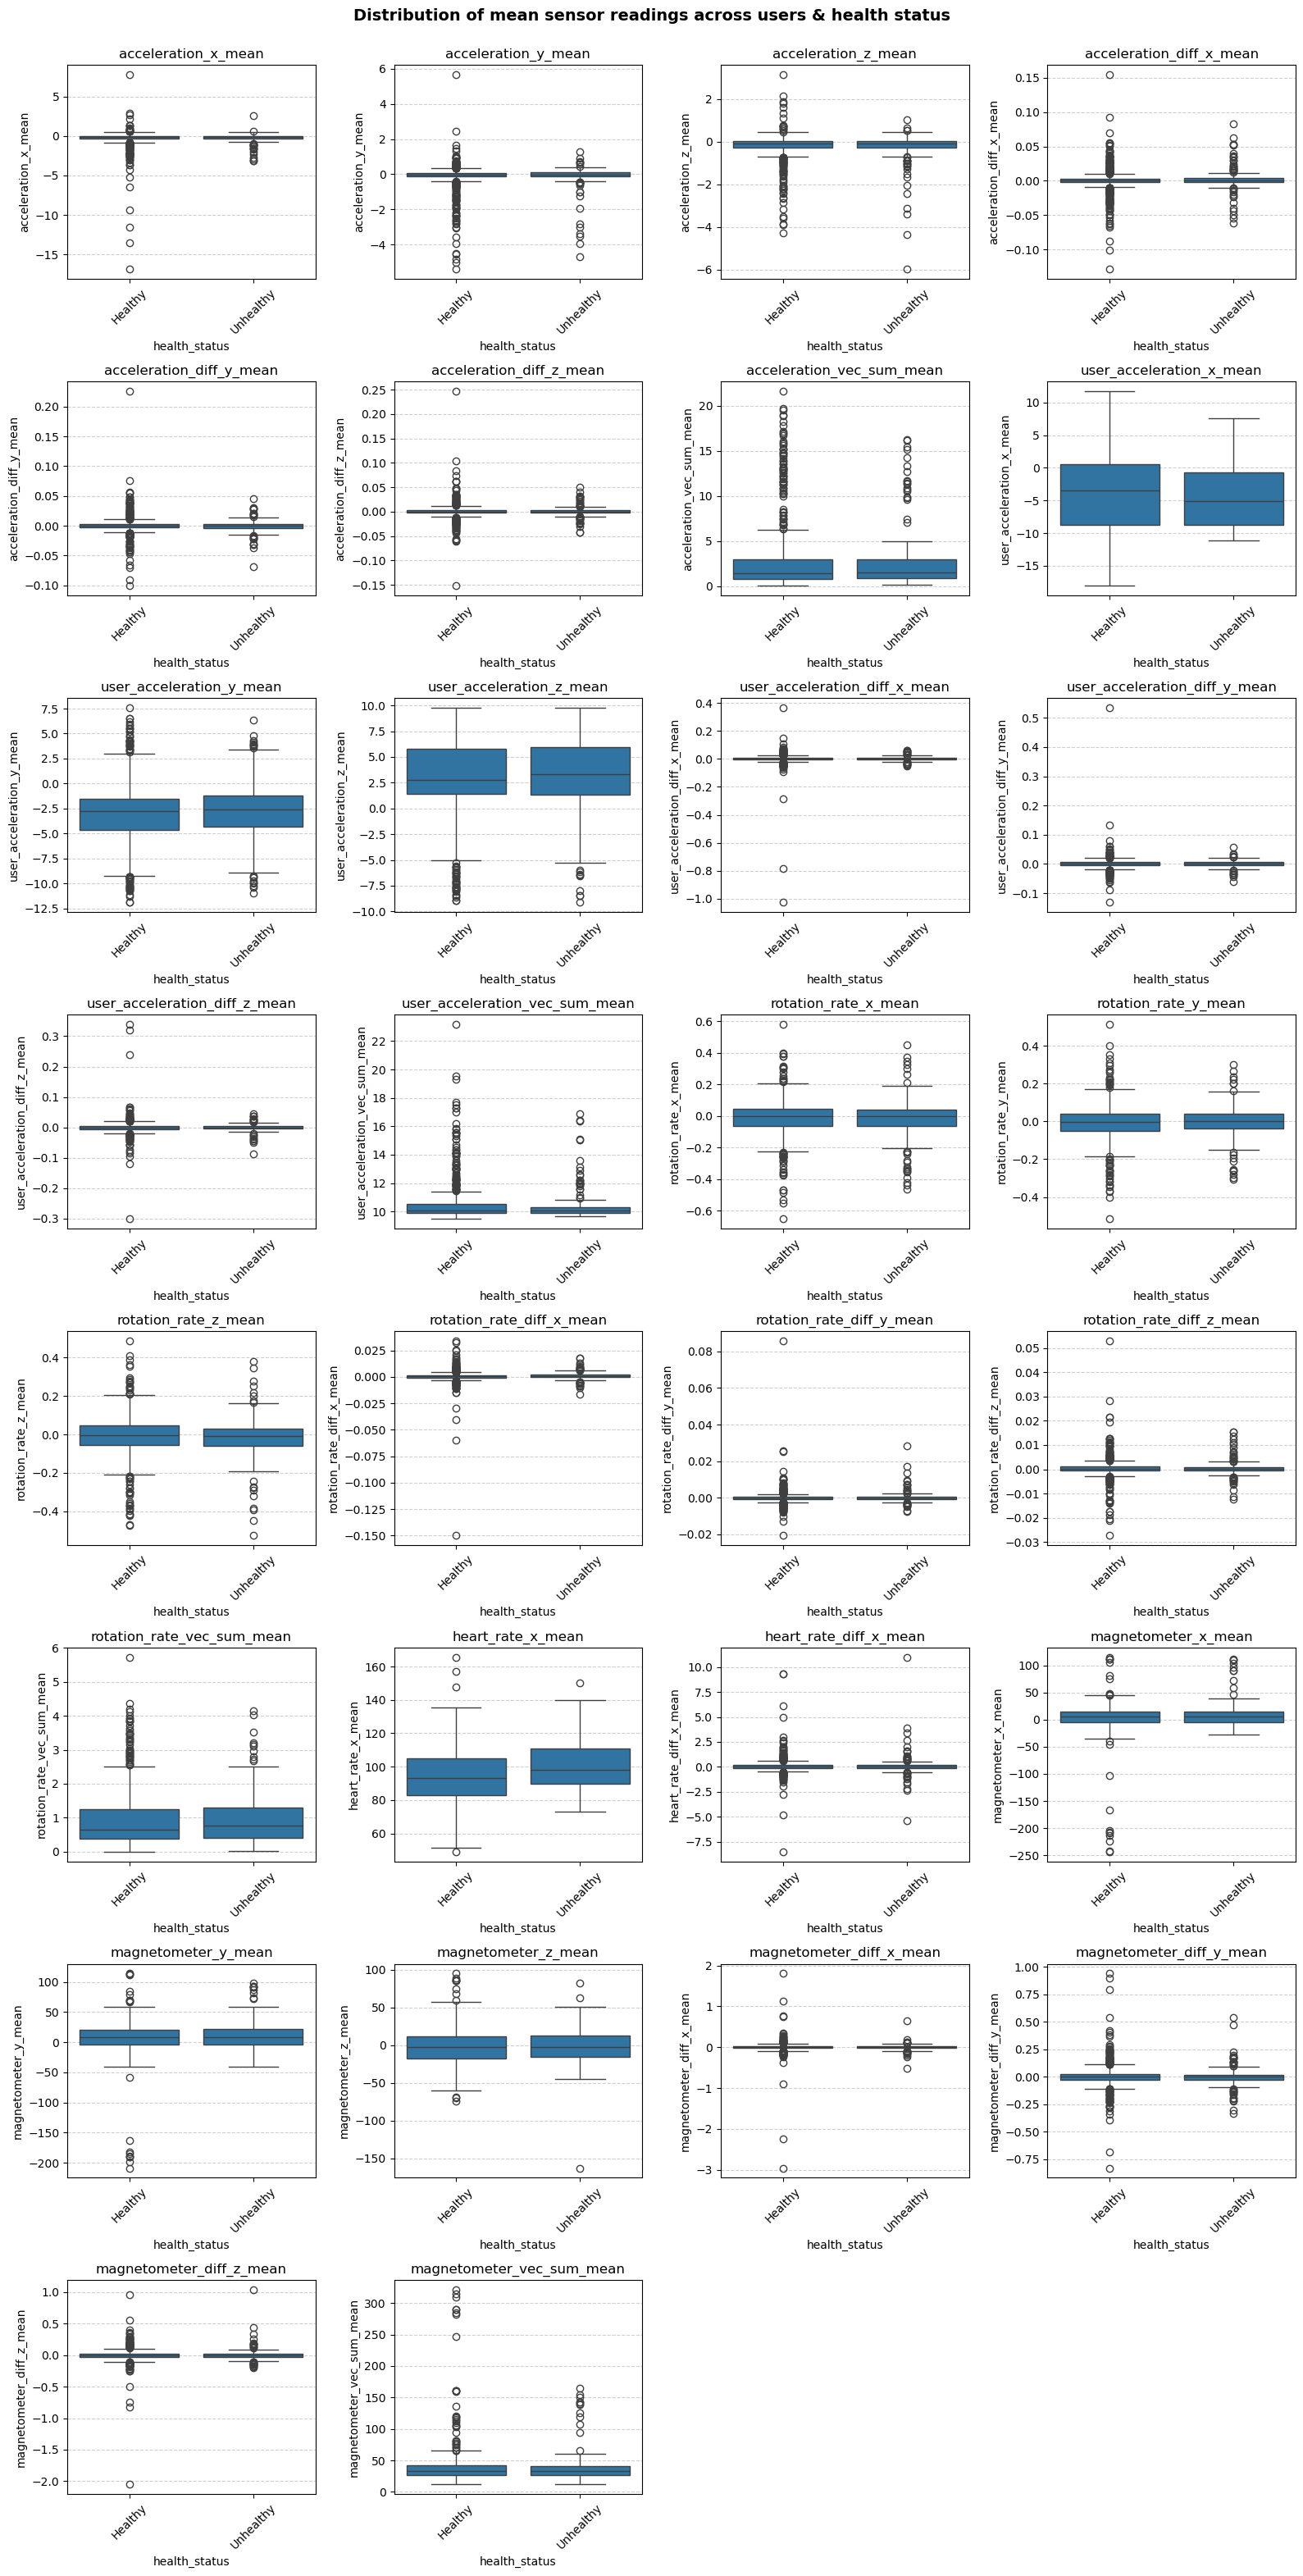

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Take only mean features for visualization
sensor_features = [col for col in df2.columns if 'mean' in col]
print(sensor_features)

n_features = len(sensor_features)
n_cols = 4 # number of columns 
n_rows = math.ceil(n_features / n_cols)  # compute required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten in case of multiple rows for easy indexing

for i, feature in enumerate(sensor_features):
    sns.boxplot(x='health_status', y=feature, data=df2, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].tick_params(axis='x', rotation=45)

# Turn off any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.suptitle('Distribution of mean sensor readings across users & health status', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave space for suptitle
plt.show()



**Observations on median/spread of mean sensor readings, across users and health status:**

Main observations:
* heart rate mean:
    * higher mean heart rate values for 'unhealthy', shown by higher median
    * greater spread in mean heart rate values for 'healthy'
* median of the mean sensor readings for all users were similar, across health status
* generally more outliers for 'healthy', across all sensors

['acceleration_x_std', 'acceleration_y_std', 'acceleration_z_std', 'acceleration_diff_x_std', 'acceleration_diff_y_std', 'acceleration_diff_z_std', 'acceleration_vec_sum_std', 'user_acceleration_x_std', 'user_acceleration_y_std', 'user_acceleration_z_std', 'user_acceleration_diff_x_std', 'user_acceleration_diff_y_std', 'user_acceleration_diff_z_std', 'user_acceleration_vec_sum_std', 'rotation_rate_x_std', 'rotation_rate_y_std', 'rotation_rate_z_std', 'rotation_rate_diff_x_std', 'rotation_rate_diff_y_std', 'rotation_rate_diff_z_std', 'rotation_rate_vec_sum_std', 'heart_rate_x_std', 'heart_rate_diff_x_std', 'magnetometer_x_std', 'magnetometer_y_std', 'magnetometer_z_std', 'magnetometer_diff_x_std', 'magnetometer_diff_y_std', 'magnetometer_diff_z_std', 'magnetometer_vec_sum_std']


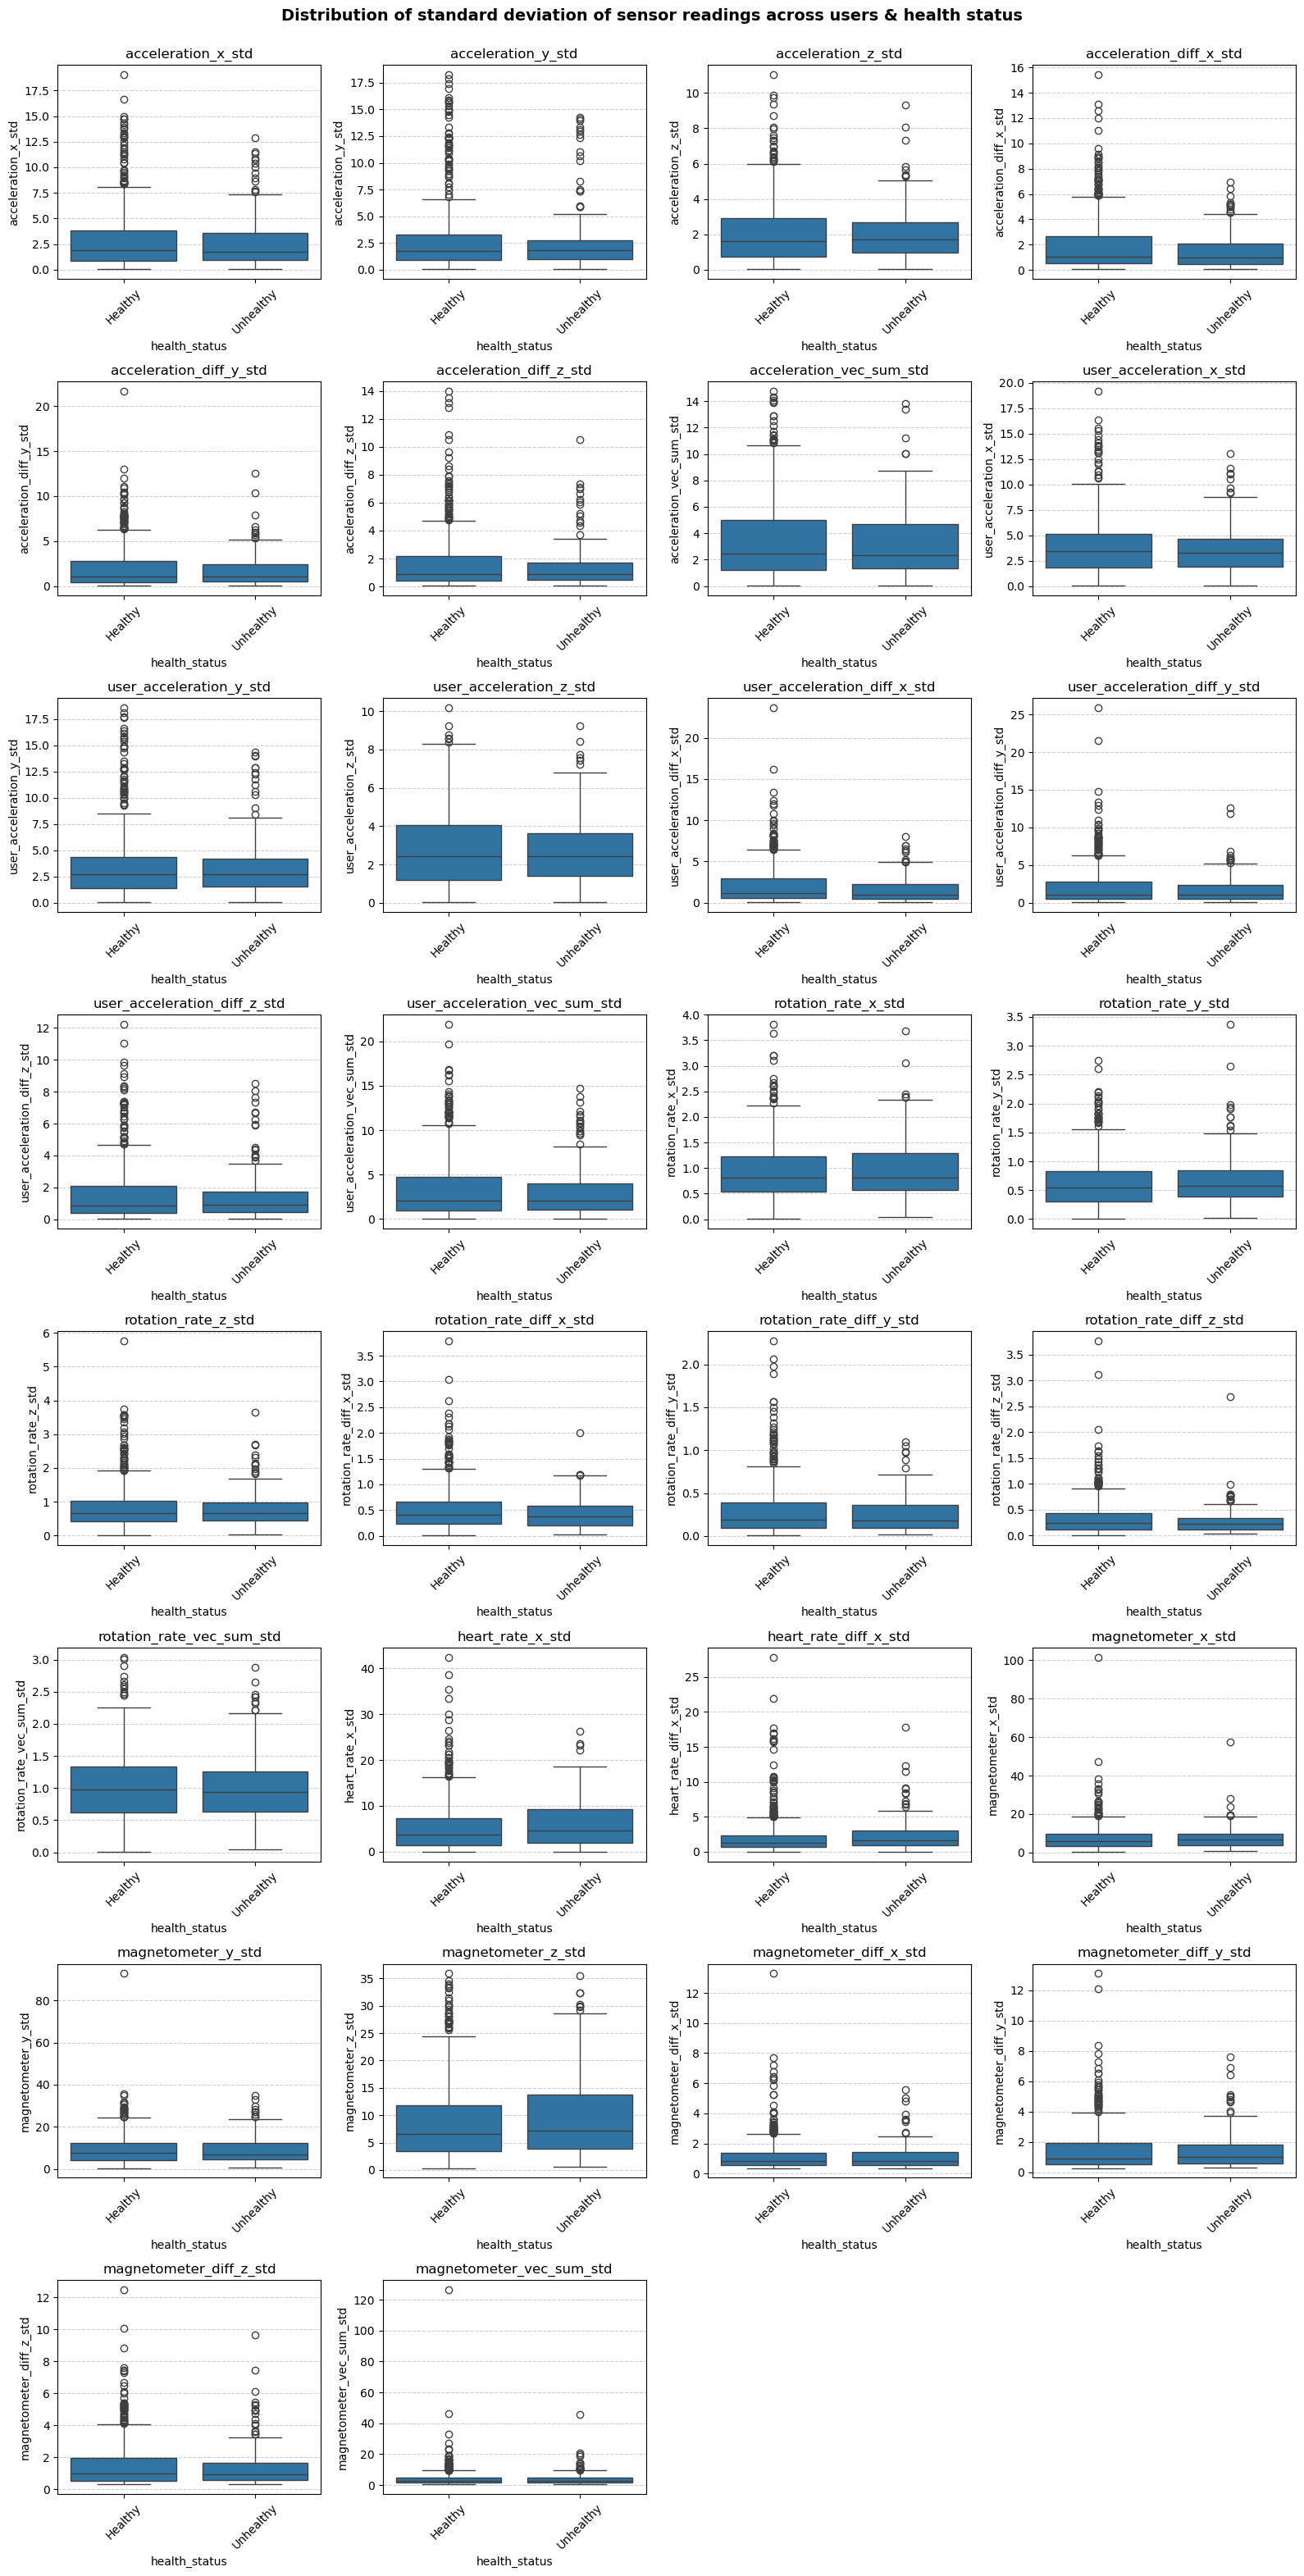

In [187]:
# Take only std features for visualization
sensor_features = [col for col in df2.columns if 'std' in col]
print(sensor_features)

n_features = len(sensor_features)
n_cols = 4 # number of columns 
n_rows = math.ceil(n_features / n_cols)  # compute required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten in case of multiple rows for easy indexing

for i, feature in enumerate(sensor_features):
    sns.boxplot(x='health_status', y=feature, data=df2, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].tick_params(axis='x', rotation=45)

# Turn off any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.suptitle('Distribution of standard deviation of sensor readings across users & health status', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave space for suptitle
plt.show()

**Observations on median/spread of standard deviation of sensor readings, across users and health status:**
Main observations:
* heart rate standard deviation:
    * higher standard deviation in heart rate values for 'unhealthy', shown by higher median of standard deviation across all unhealthy users
* median of the standard deviation of sensor readings for all users were similar, across health status
* generally more outliers for 'healthy', across all sensors


## How numeric features affect target

In [189]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

# Copy all numerical columns from df into separate df
df_num = df2.select_dtypes(include='number').copy()

# Encode categorical target
le = LabelEncoder()
y_encoded = le.fit_transform(df2['activity_label'])

# Drop rows with any NaN values in the features or target (SelectKBest cannot take NaN, but cannot impute now)
temp_df = pd.concat([df_num, df2['activity_label']], axis=1).dropna()
X_clean = temp_df[df_num.columns]
y_clean = temp_df[df2['activity_label'].name]

# SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X_clean, y_clean)

# Pair feature names with their scores
feature_scores = pd.DataFrame({
    'Feature': df_num.columns,
    'F-statistic Score': selector.scores_,
    'P-value score': selector.pvalues_
}).sort_values(by='F-statistic Score', ascending=False)

print(feature_scores)

                           Feature  F-statistic Score  P-value score
41      rotation_rate_vec_sum_mean         176.463242   7.226462e-88
12         acceleration_diff_z_std         156.849474   5.235988e-80
26    user_acceleration_diff_z_std         155.948961   1.226003e-79
58         magnetometer_diff_z_std         120.200397   2.657255e-64
56         magnetometer_diff_y_std         117.299099   5.370263e-63
14        acceleration_vec_sum_std         112.796259   5.965826e-61
6               acceleration_z_std         112.251031   1.059248e-60
15        user_acceleration_x_mean         110.204337   9.206624e-60
13       acceleration_vec_sum_mean          92.499574   2.014773e-51
20         user_acceleration_z_std          90.455687   1.963276e-50
52              magnetometer_z_std          89.362650   6.668629e-50
22    user_acceleration_diff_x_std          88.965117   1.041301e-49
8          acceleration_diff_x_std          85.754939   3.875166e-48
10         acceleration_diff_y_std

* Higher F-score shows that the feature discriminates between the activity categories better.
* Features with very low F-score or high p-value are weak predictors.

Strong predictors:
* rotation_rate_vec_sum_mean
* acceleration_diff_z_std 
* user_acceleration_diff_z_std

Weak predictors:
* user_id -> expected
* acceleration_diff_y_mean
* rotation_rate_diff_y_mean

#### If health_status was the target

In [195]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

# Copy all numerical columns from df into separate df
df_num = df2.select_dtypes(include='number').copy()

# Encode categorical target
le = LabelEncoder()
y_encoded = le.fit_transform(df2['health_status'])

# Drop rows with any NaN values in the features or target (SelectKBest cannot take NaN, but cannot impute now)
temp_df = pd.concat([df_num, df2['health_status']], axis=1).dropna()
X_clean = temp_df[df_num.columns]
y_clean = temp_df[df2['health_status'].name]

# SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X_clean, y_clean)

# Pair feature names with their scores
feature_scores = pd.DataFrame({
    'Feature': df_num.columns,
    'F-statistic Score': selector.scores_,
    'P-value score': selector.pvalues_
}).sort_values(by='F-statistic Score', ascending=False)

print(feature_scores)

                           Feature  F-statistic Score  P-value score
0                          user_id          36.002512   2.976965e-09
43               heart_rate_x_mean          17.622461   2.994141e-05
40        rotation_rate_diff_z_std           7.475070   6.393322e-03
36        rotation_rate_diff_x_std           6.354929   1.189771e-02
8          acceleration_diff_x_std           6.322863   1.211301e-02
22    user_acceleration_diff_x_std           5.460532   1.969512e-02
15        user_acceleration_x_mean           5.168668   2.326047e-02
47             magnetometer_x_mean           4.053791   4.440464e-02
49             magnetometer_y_mean           3.932221   4.770883e-02
44                heart_rate_x_std           3.688852   5.513026e-02
38        rotation_rate_diff_y_std           3.573177   5.907883e-02
52              magnetometer_z_std           3.448834   6.366147e-02
24    user_acceleration_diff_y_std           3.273500   7.078015e-02
10         acceleration_diff_y_std

It doesn't seem possible to determine healthy/unhealthy labels from this dataset as the user_id is the most discriminating feature here...

## Correlation check

### Numeric

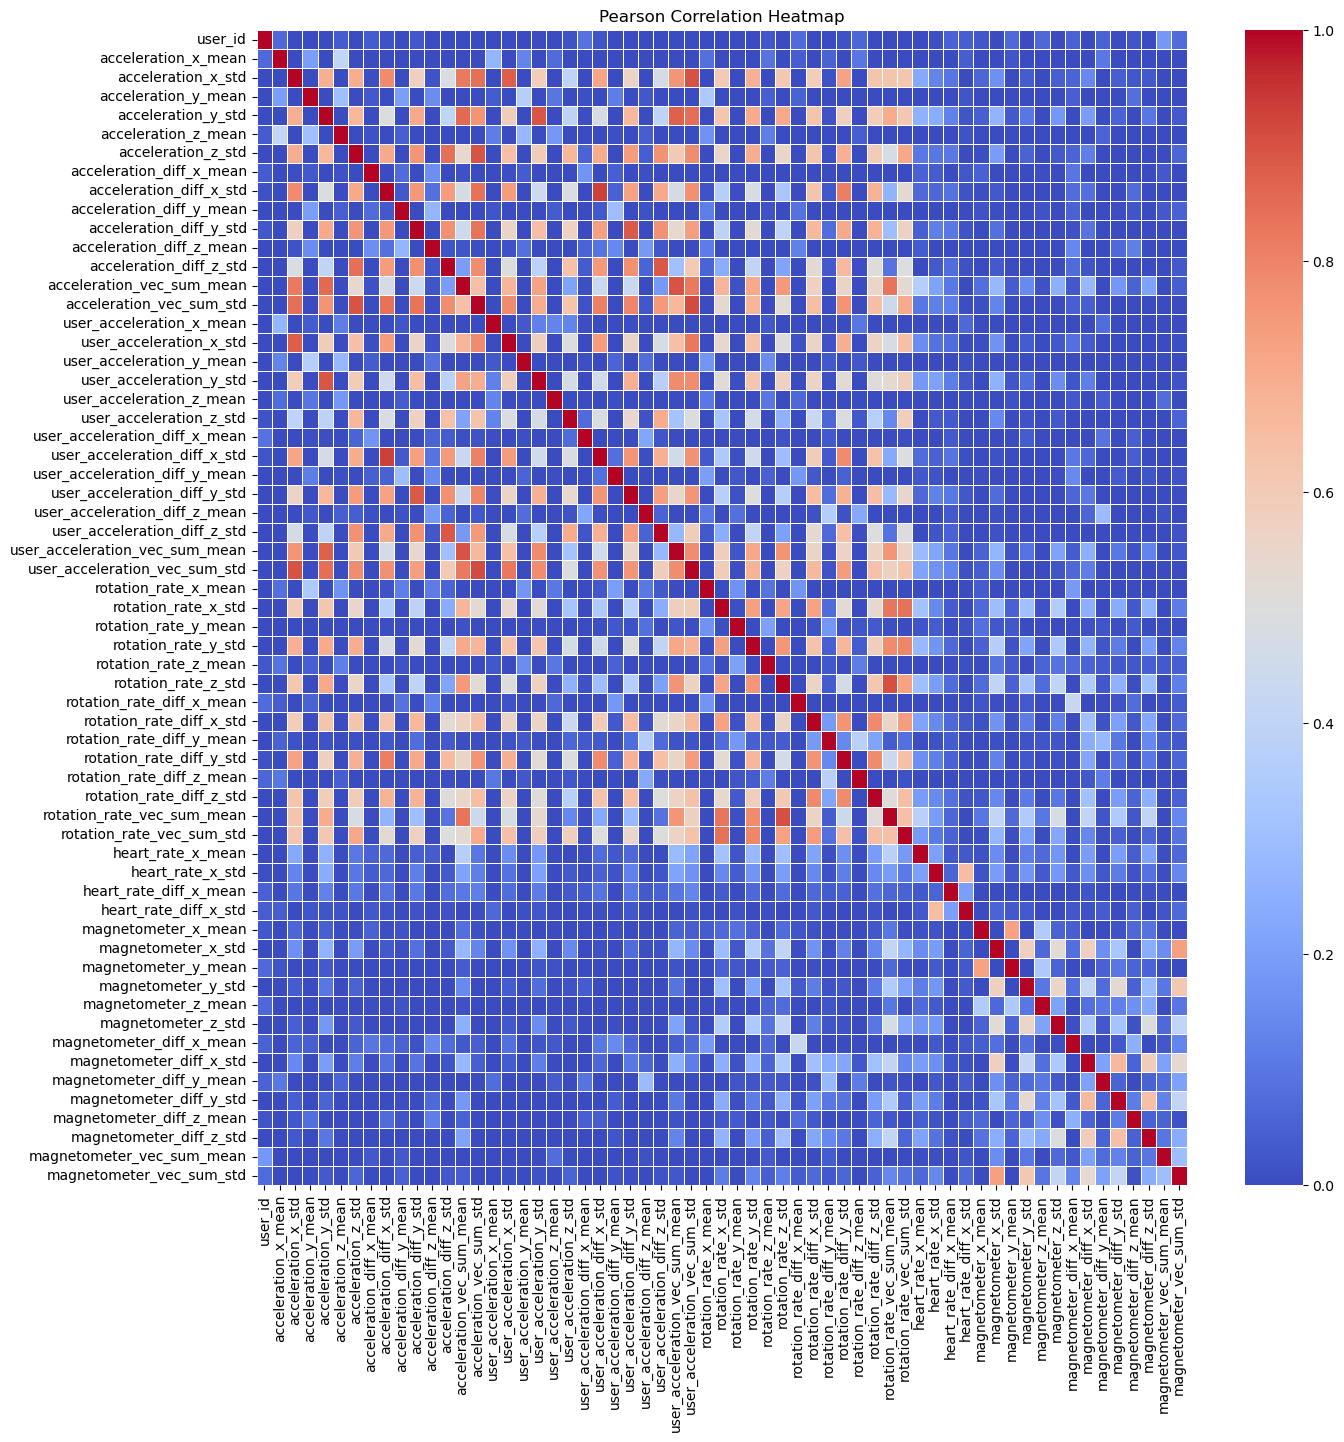

acceleration_diff_x_std - user_acceleration_diff_x_std: 0.93
acceleration_vec_sum_std - user_acceleration_vec_sum_std: 0.91
rotation_rate_z_std - rotation_rate_vec_sum_mean: 0.90
acceleration_x_std - user_acceleration_vec_sum_std: 0.90
acceleration_z_std - acceleration_vec_sum_std: 0.90
acceleration_vec_sum_mean - user_acceleration_vec_sum_mean: 0.90
acceleration_y_std - user_acceleration_y_std: 0.89
acceleration_diff_z_std - user_acceleration_diff_z_std: 0.89
acceleration_diff_y_std - user_acceleration_diff_y_std: 0.89
acceleration_x_std - user_acceleration_x_std: 0.88
acceleration_y_std - user_acceleration_vec_sum_mean: 0.87
acceleration_y_std - acceleration_vec_sum_mean: 0.86
acceleration_y_std - user_acceleration_vec_sum_std: 0.85
acceleration_x_std - acceleration_vec_sum_std: 0.84
acceleration_z_std - acceleration_diff_z_std: 0.84
acceleration_diff_x_std - acceleration_vec_sum_std: 0.84
rotation_rate_x_std - rotation_rate_vec_sum_std: 0.84
acceleration_vec_sum_mean - rotation_rate

In [209]:
df_num = df2.select_dtypes(include='number').copy()
# Calculate the Pearson Correlation Matrix
corr_matrix_pear = df_num.corr(method='pearson')

# Plot the heatmap of the correlation matrix for the entire dataset
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix_pear, annot=False, cmap='coolwarm', vmin=0, center=0.5, vmax=1, linewidths=0.5, fmt='.2f')
plt.title('Pearson Correlation Heatmap')
plt.show()

# Collect high-correlation pairs
high_corr_pairs = []
mid_corr_pairs = []

for i in range(len(corr_matrix_pear.columns)):
    for j in range(i+1, len(corr_matrix_pear.columns)):
        col1 = corr_matrix_pear.columns[i]
        col2 = corr_matrix_pear.columns[j]
        corr_value = corr_matrix_pear.iloc[i, j]
        if abs(corr_value) >= 0.8:
            high_corr_pairs.append((col1, col2, corr_value))
        elif 0.6 < abs(corr_value) < 0.8:
            mid_corr_pairs.append((col1, col2, corr_value))

# Sort by absolute correlation in descending order
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print
for col1, col2, corr_value in high_corr_pairs:
    print(f"{col1} - {col2}: {corr_value:.2f}")

print(f"\n{len(mid_corr_pairs)} pairs with moderate linear correlation (0.6 to 0.8)")

For each correlated feature pair with .corr() > 0.8, we will keep the feature with the higher F-score.


In [ ]:
features_to_drop = [
    # Highly correlated (redundant) features
    'acceleration_diff_x_std',
    'rotation_rate_z_std',
    'acceleration_x_std',
    'user_acceleration_x_std',
    'acceleration_y_std',
    'acceleration_diff_z_std',
    'acceleration_diff_y_std',
    'acceleration_z_std',
    'rotation_rate_x_std',
    'rotation_rate_y_std',
    'acceleration_vec_sum_mean',
    'acceleration_vec_sum_std',

    # Very weak ANOVA predictors
    'rotation_rate_diff_y_mean',
    'user_id',
    'magnetometer_diff_x_mean',
    'acceleration_diff_y_mean',
    'rotation_rate_diff_x_mean',
    'rotation_rate_diff_z_mean',
    'heart_rate_diff_x_mean'
]

df3 = df2.drop(columns=features_to_drop)


## Missing values

In [210]:
# Detecting missing values
missing_list = list(df3.columns[df3.isna().any()])       

# Percentage of missing values
row_count = df3.shape[0] 
# Create list of dicts (one per column)
data = []
for col in missing_list:
    count = df3[col].isnull().sum()
    percent = (count / row_count) * 100
    data.append({
        'Columns with missing values': col,
        'Missing count': count,
        'Missing %': percent,
        'DataType' : df3[col].dtype
    })

# Create DataFrame from list of dicts
missing_df = pd.DataFrame(data)
print(missing_df)

  Columns with missing values  Missing count  Missing % DataType
0            heart_rate_x_std              9   1.102941  float64
1       heart_rate_diff_x_std              9   1.102941  float64


In [211]:
# Checking if missing values have a common pattern (13)

null_val = df3[df3['heart_rate_x_std'].isnull()]
print(null_val.shape)
for column in null_val.columns:
    print(null_val[column].value_counts(),"\n")

(9, 45)
activity_label
Exercise    4
Fall        3
Sleep       2
Name: count, dtype: int64 

acceleration_x_mean
-0.409282    1
 0.006174    1
 0.009353    1
-1.973457    1
-0.010947    1
 0.074109    1
 0.018031    1
-0.084038    1
 0.020249    1
Name: count, dtype: int64 

acceleration_y_mean
-0.406006    1
-0.005614    1
-0.058456    1
-0.469417    1
-0.614813    1
-0.112795    1
-0.002334    1
-0.024251    1
-0.045224    1
Name: count, dtype: int64 

acceleration_z_mean
 0.178431    1
 0.158476    1
-0.148862    1
-0.011562    1
 0.419407    1
 0.037517    1
 0.098477    1
 0.011662    1
 0.020703    1
Name: count, dtype: int64 

acceleration_diff_x_mean
-0.019532    1
-0.004587    1
 0.000493    1
-0.021701    1
 0.024590    1
-0.002450    1
 0.083378    1
-0.007927    1
 0.021939    1
Name: count, dtype: int64 

acceleration_diff_z_mean
-0.010837    1
 0.001844    1
-0.010482    1
-0.002299    1
-0.008342    1
 0.000601    1
-0.009981    1
-0.006667    1
 0.002613    1
Name: coun

No common user_id or activity_label

In [212]:
import plotly.express as px
import plotly.io as pio

# Set the default renderer to open plots in your web browser ('browser') or inline ('notebook')
pio.renderers.default = 'browser' 

# Subset only columns with missing values, sorted in a certain way to view correlations
missing_list_sort = ['heart_rate_x_std', 
                     'heart_rate_diff_x_std']

missing_df = df3[missing_list_sort]

# Filter rows with missing values
missing_rows = missing_df[missing_df.isnull().any(axis=1)]

# Create boolean DataFrame of missing values
mask = missing_rows.isnull()

# Convert to long format for Plotly heatmap
mask_long = mask.reset_index().melt(id_vars='index', var_name='Column', value_name='Is Missing')

# Plot interactive heatmap
fig = px.imshow(
    mask.values,
    labels=dict(x="Column", y="Row Index", color="Missing"),
    x=mask.columns,
    y=mask.index,
    color_continuous_scale=["#ffffff", "#636efa"],  # white for present, blue for missing
    aspect="auto"
)

fig.update_layout(title="Interactive Missing Data Heatmap", height=600)
fig.show()

the missing data in the 2 columns occur in the same rows.

## Clean up unwanted columns

In [213]:
# # keywords of columns to keep
# eng_cols = ['mean', 'std', 'activity', 'id', 'health', 'age']

# # Filter columns that contain any of the keywords
# columns_to_keep = [col for col in df3.columns if any(k in col.lower() for k in eng_cols)]

# # Create a new filtered DataFrame
# df3 = df3[columns_to_keep]
# print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, 0 to 979
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   activity_label                  816 non-null    object 
 1   acceleration_x_mean             816 non-null    float64
 2   acceleration_y_mean             816 non-null    float64
 3   acceleration_z_mean             816 non-null    float64
 4   acceleration_diff_x_mean        816 non-null    float64
 5   acceleration_diff_z_mean        816 non-null    float64
 6   user_acceleration_x_mean        816 non-null    float64
 7   user_acceleration_y_mean        816 non-null    float64
 8   user_acceleration_y_std         816 non-null    float64
 9   user_acceleration_z_mean        816 non-null    float64
 10  user_acceleration_z_std         816 non-null    float64
 11  user_acceleration_diff_x_mean   816 non-null    float64
 12  user_acceleration_diff_x_std    816 non-n

## Saving ADL falls dataset

In [214]:
# Save renamed ADL falls dataset
# df2.to_csv("ADLfalls_renamed.csv", index=False)
df3.to_csv("ADLfalls_renamed_relabelledHealth_limitedActivities_trimmed.csv", index=False)
